<a href="https://colab.research.google.com/github/ishankarve/Linear-Regression/blob/main/Multiple%20Linear%20Regression%20in%20Python/Assignment/Bike%20Sharing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Objective**
Build a multiple linear regression model for the prediction of demand for shared bikes. 

### **Problem Statement**

A US bike-sharing provider **BoomBikes** has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state. 

In such an attempt, BoomBikes aspires to understand the demand for shared bikes among the people after this ongoing quarantine situation ends across the nation due to Covid-19. 


### **Business Goal**

Find variables are significant in predicting the demand for shared bikes and how well those variables describe the bike demands
Based on various **meteorological surveys** and people's styles, the service provider firm has gathered a large dataset on daily bike demands across the American market based on some factors. 

Based on the goal mentioned above, model the demand for shared bikes with the available independent variables.

### **Data Caveats**

1.   In the dataset that some of the variables like 'weathersit' and 'season' have values as 1, 2, 3, 4 which have specific labels associated with them (as described in the data dictionary). These numeric values associated with the labels may indicate that there is some order to them - which is actually not the case. So, it is advisable to convert such feature values into categorical string values before proceeding with model building.

2.  The column 'yr' has two values 0 and 1 indicating the years 2018 and 2019 respectively. Since these bike-sharing systems are slowly gaining popularity, the demand for these bikes is increasing every year proving that the column 'yr' might be a good variable for prediction. So think twice before dropping it. 


### **Model Building**

In the dataset provided,there are three columns named 'casual', 'registered', and 'cnt'. The variable 'casual' indicates the number casual users who have made a rental. The variable 'registered' on the other hand shows the total number of registered users who have made a booking on a given day. Finally, the 'cnt' variable indicates the total number of bike rentals, including both casual and registered. ***The model should be built taking this 'cnt' as the target variable.***

### **Step 1: Import Libraries**


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

### **Step 2: Import Data**

In [3]:
#import data from gihub link
df_bikeshare=pd.read_csv("https://raw.githubusercontent.com/ishankarve/Linear-Regression/main/Multiple%20Linear%20Regression%20in%20Python/Assignment/day.csv")

In [4]:
df_bikeshare.head(730)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,726,27-12-2019,1,1,12,0,4,1,2,10.420847,11.33210,65.2917,23.458911,247,1867,2114
726,727,28-12-2019,1,1,12,0,5,1,2,10.386653,12.75230,59.0000,10.416557,644,2451,3095
727,728,29-12-2019,1,1,12,0,6,0,2,10.386653,12.12000,75.2917,8.333661,159,1182,1341
728,729,30-12-2019,1,1,12,0,0,0,1,10.489153,11.58500,48.3333,23.500518,364,1432,1796


# **Data Dictionary**
- instant: record index
- dteday : date
- season : season (1:spring, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2018, 1:2019)
- mnth : month ( 1 to 12)
- holiday : whether day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : temperature in Celsius
- atemp: feeling temperature in Celsius
- hum: humidity
- windspeed: wind speed
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

### **Step 3: Undertake sanity checks on data**

In [5]:
#get shape of the dataframe
df_bikeshare.shape

(730, 16)

In [6]:
#check column dtypes
df_bikeshare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [7]:
#get list of unique variables per column
print(df_bikeshare.nunique())

instant       730
dteday        730
season          4
yr              2
mnth           12
holiday         2
weekday         7
workingday      2
weathersit      3
temp          498
atemp         689
hum           594
windspeed     649
casual        605
registered    678
cnt           695
dtype: int64


In [8]:
# get count of non-na values across all columns
df_bikeshare.apply(lambda x: x.count(), axis=0)

instant       730
dteday        730
season        730
yr            730
mnth          730
holiday       730
weekday       730
workingday    730
weathersit    730
temp          730
atemp         730
hum           730
windspeed     730
casual        730
registered    730
cnt           730
dtype: int64

In [9]:
# convert 'dteday' from 'object' to 'datetime'
df_bikeshare['dteday'] = pd.to_datetime(df_bikeshare['dteday'], format='%d-%m-%Y') #date is in 01-01-2018 format

In [10]:
#describe dataframe
df_bikeshare.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


### **Step 4: Cleaning & Binning Numerical Categorical Data**

In [11]:
#using 'OR' operation for holiday and working day to make holiday column redundant
df_bikeshare['workingday']=df_bikeshare['workingday'] + df_bikeshare['holiday']
#drop 'holiday' column
df_bikeshare.drop(['holiday'], axis = 1, inplace = True)


In [12]:
# binning windspeed data as per Beaufort Scale (https://www.rmets.org/metmatters/beaufort-scale)
# Note: Since temperature is in metric units (deg Celsius), it is assumed that windspeed is in Km/Hr

#bin_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
bin_labels = ['Calm','Light_air','Light_Breeze','Gentle_Breeze','Moderate_Breeze','Fresh_Breeze','Strong_Breeze','Moderate_Gale','Fresh_Gale','Strong_Gale','Whole_Gale','Storm','Hurricane']

bins = [0, 1, 5, 11, 19, 28, 38, 49, 61, 74, 88, 102, 117,300]
df_bikeshare['windspeed_binned'] = pd.cut(df_bikeshare['windspeed'], bins=bins, labels=bin_labels)

In [13]:
# binning temperature data as per comfort Scale (http://www.city-data.com/forum/weather/1620160-your-personal-temperature-colors-descriptors.html)
# data is binned as follows
# data is binned on a scale of 1 to 12
# 12- 45C & up: extremely hot 
# 11- 40 to 45C: very hot 
# 10- 35 to 40C: hot 
# 09- 30 to 35C: quite warm 
# 08 -20 to 30C: ideal 
# 07- 15 to 20C: lower than ideal 
# 06- 10 to 15C: cool 
# 05- 5 to 10C: quite cool 
# 04- 0 to 5C: cold 
# 03 -5 to 0C: very cold 
# 02- -10 to -5C: freezing 
# 01- -15 to -10C: frigid

#bin_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
bin_labels = ['Frigid','Freezing','Very_Cold','Cold','Quite_Cool','Cool','Lower_Ideal','Ideal','Quite_Warm','Hot','Very_Hot','Extremely_Hot']
bins = [-15,-10,-5,0,5,10,15,20,30,35,40,45,60]
df_bikeshare['temp_binned'] = pd.cut(df_bikeshare['temp'], bins=bins, labels=bin_labels)

In [14]:
#extracting day from date
df_bikeshare["day"]=df_bikeshare.dteday.dt.day

In [15]:
#binning months into quarters (1st,2nd,3rd,4th)
bin_labels = ['First', 'Second', 'Third', 'Fourth']
bins = [0,3,6,8,12]
df_bikeshare['quarter_binned'] = pd.cut(df_bikeshare['mnth'], bins=bins, labels=bin_labels)

In [16]:
#binning weekday  into labelled bins
bin_labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday','Thursday','Friday','Saturday']
bins = [-1,0,1,2,3,4,5,6]
df_bikeshare['weekday_binned'] = pd.cut(df_bikeshare['weekday'], bins=bins, labels=bin_labels)

In [17]:
#binning humidity  into labelled bins
bin_labels = ['Too_Dry','Much_Dry', 'Dry', 'Near_Perfect', 'Perfect','About_Perfect','Sweaty', 'Too_Humid','Gross']
bins = [0, 10, 20, 30, 40, 60, 70, 80, 90, 100]
df_bikeshare['hum_binned'] = pd.cut(df_bikeshare['hum'], bins=bins, labels=bin_labels)

In [18]:
#binning months into labelled months)
bin_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
df_bikeshare['mnth_binned'] = pd.cut(df_bikeshare['mnth'], bins=bins, labels=bin_labels)

In [19]:
#binning months into labelled months)
bin_labels = ['Clear', 'Cloudy', 'Light_RainSnow', 'Heavy_RainSnow']
bins = [0, 1, 2, 3, 4]
df_bikeshare['weathersit_binned'] = pd.cut(df_bikeshare['weathersit'], bins=bins, labels=bin_labels)

In [20]:
#binning seasons into labelled variables
bin_labels = ['Spring', 'Summer', 'Autumn', 'Winter']
bins = [0, 1, 2, 3, 4]
df_bikeshare['season_binned'] = pd.cut(df_bikeshare['season'], bins=bins, labels=bin_labels)

### **Step 5: Prelimnary Visualisation**
Since all data is numeric, we can use plots to visualise data 

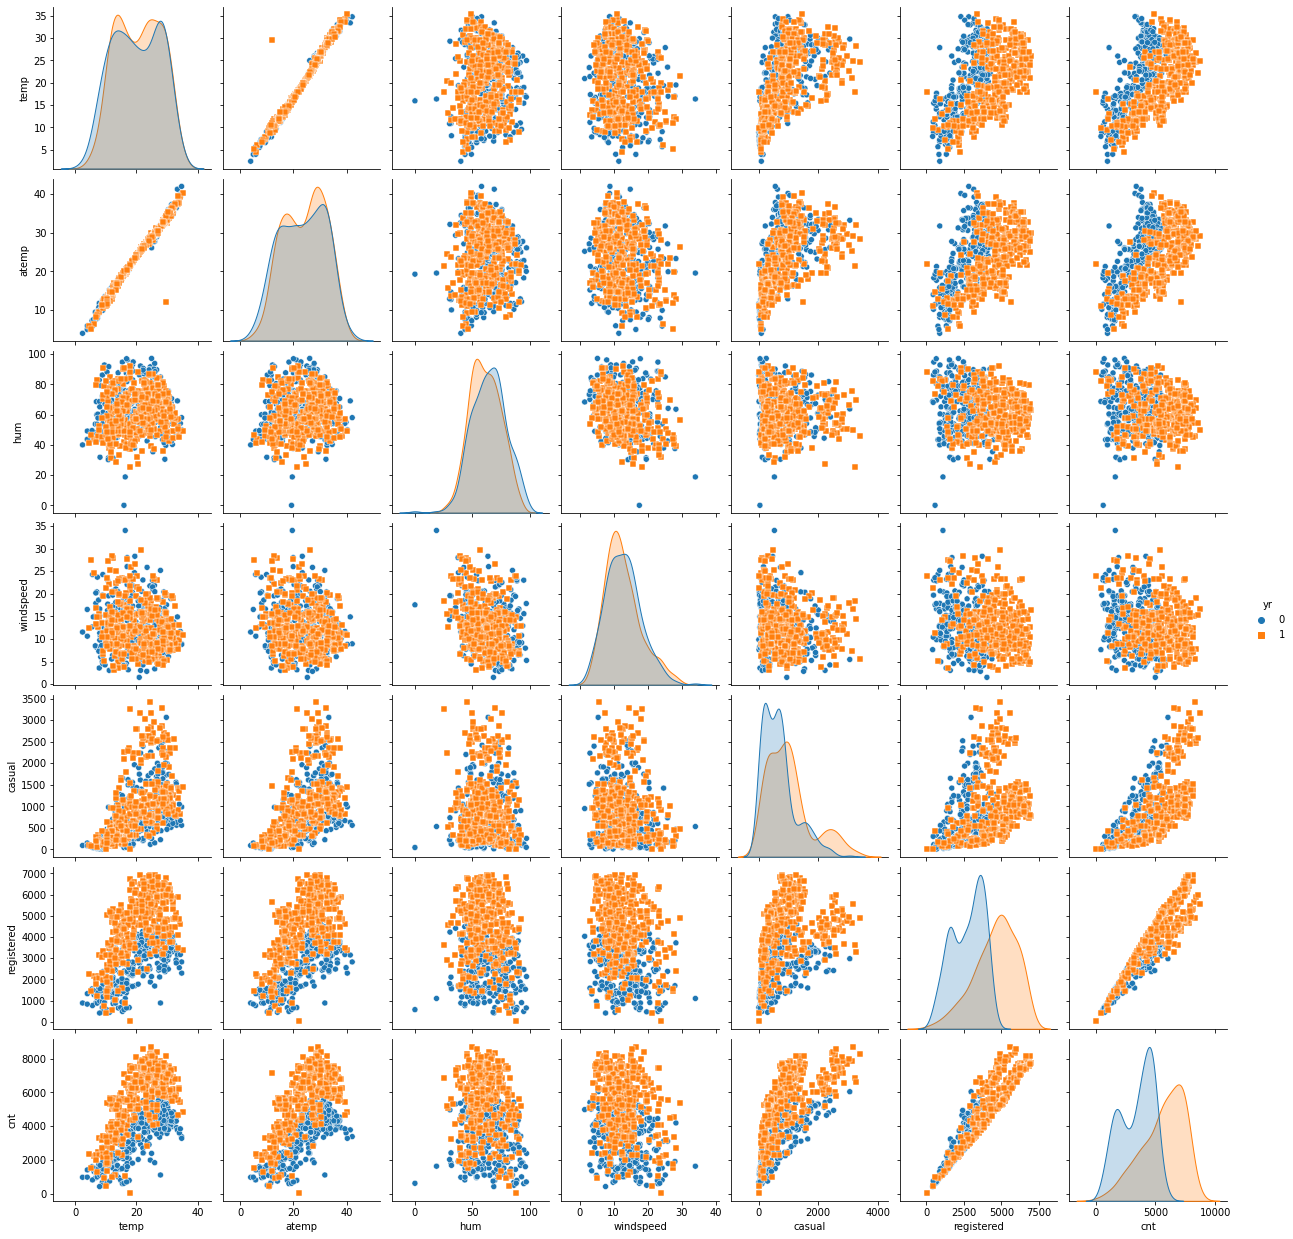

In [21]:
#plotting pairplot of continious variables
#Reference: https://stackoverflow.com/questions/64556501/plot-only-some-columns-with-seaborn-pairplot
cols_to_plot = df_bikeshare.columns[8:15].tolist() + ['yr'] # explicitly add the column "yr" to your list of columns to plot
sns.pairplot(df_bikeshare[cols_to_plot], hue ="yr", markers=["o", "s"])
plt.show()


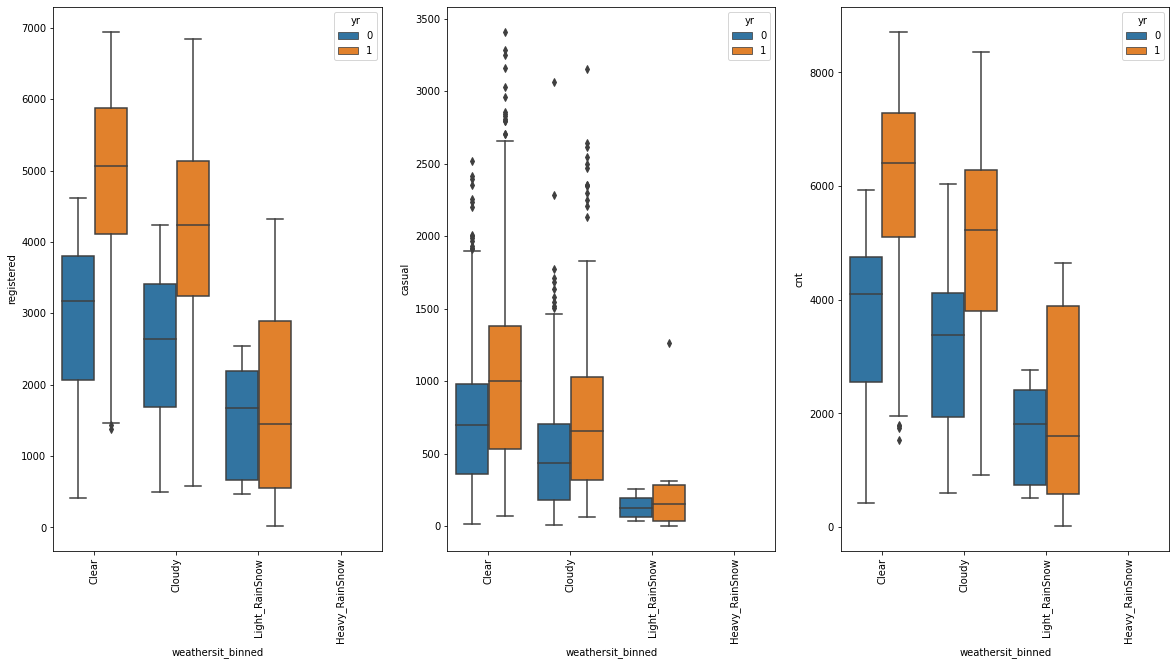

In [22]:
#plotting data for comparative analysis
plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
sns.boxplot(x = 'weathersit_binned', y = 'registered', hue = 'yr', data = df_bikeshare)
plt.xticks(rotation='vertical')
plt.subplot(1,3,2)
sns.boxplot(x = 'weathersit_binned', y = 'casual', hue = 'yr', data = df_bikeshare)
plt.xticks(rotation='vertical')
plt.subplot(1,3,3)
sns.boxplot(x = 'weathersit_binned', y = 'cnt', hue = 'yr', data = df_bikeshare)
plt.xticks(rotation='vertical')
plt.show()

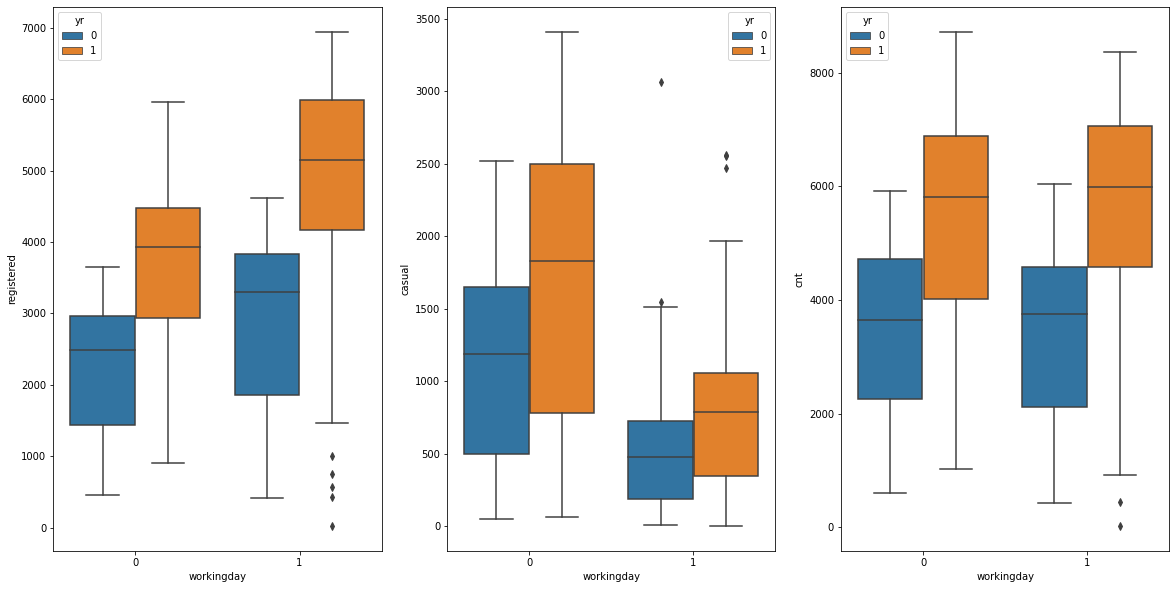

In [23]:
#plotting data for comparative analysis
plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
sns.boxplot(x = 'workingday', y = 'registered', hue = 'yr', data = df_bikeshare)
plt.subplot(1,3,2)
sns.boxplot(x = 'workingday', y = 'casual', hue = 'yr', data = df_bikeshare)
plt.subplot(1,3,3)
sns.boxplot(x = 'workingday', y = 'cnt', hue = 'yr', data = df_bikeshare)
plt.show()

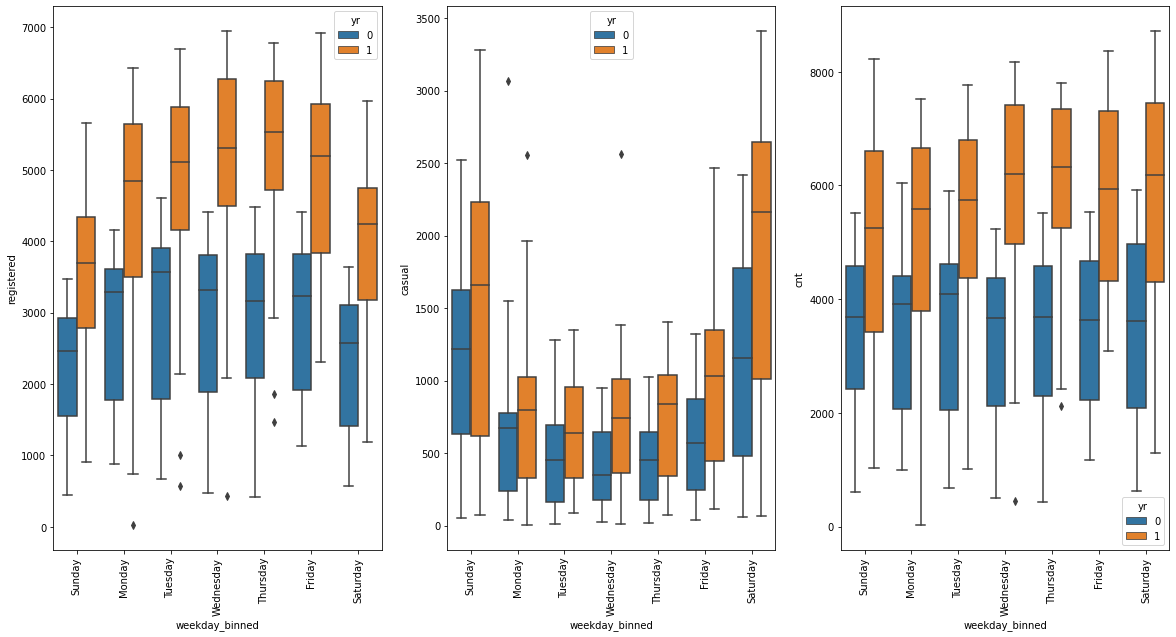

In [24]:
#plotting data for comparative analysis
plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
sns.boxplot(x = 'weekday_binned', y = 'registered', hue = 'yr', data = df_bikeshare)
plt.xticks(rotation='vertical')
plt.subplot(1,3,2)
sns.boxplot(x = 'weekday_binned', y = 'casual', hue = 'yr', data = df_bikeshare)
plt.xticks(rotation='vertical')
plt.subplot(1,3,3)
sns.boxplot(x = 'weekday_binned', y = 'cnt', hue = 'yr', data = df_bikeshare)
plt.xticks(rotation='vertical')
plt.show()

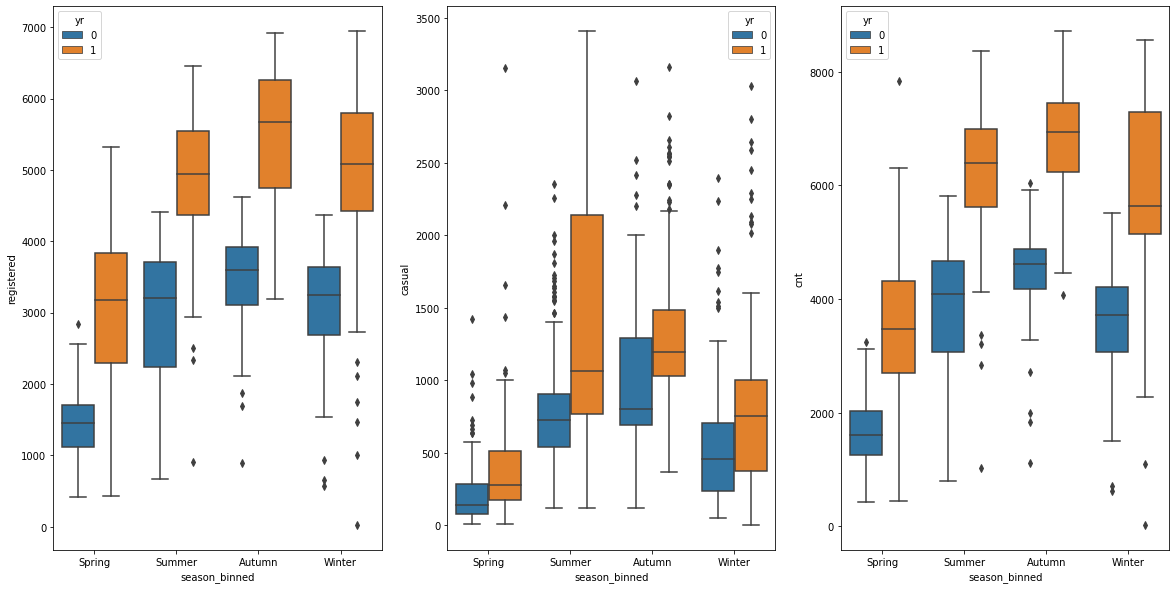

In [25]:
#plotting data for comparative analysis
plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
sns.boxplot(x = 'season_binned', y = 'registered', hue = 'yr', data = df_bikeshare)
plt.subplot(1,3,2)
sns.boxplot(x = 'season_binned', y = 'casual', hue = 'yr', data = df_bikeshare)
plt.subplot(1,3,3)
sns.boxplot(x = 'season_binned', y = 'cnt', hue = 'yr', data = df_bikeshare)
plt.show()

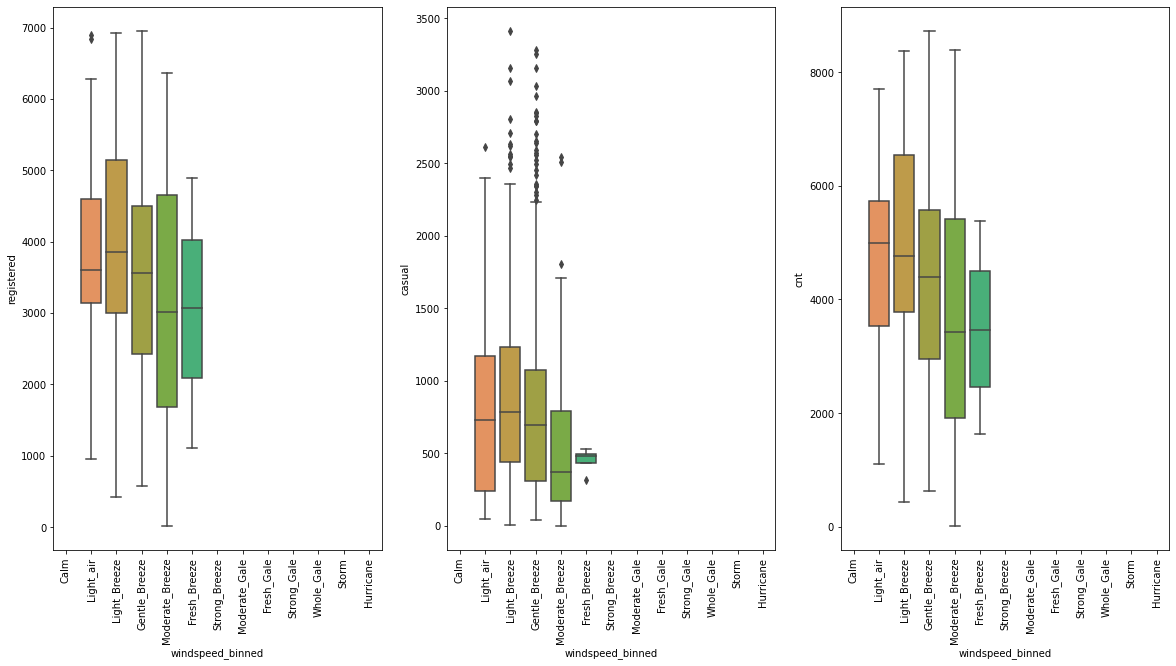

In [26]:
#plotting data for comparative analysis
plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
sns.boxplot(x = 'windspeed_binned', y = 'registered', data = df_bikeshare)
plt.xticks(rotation='vertical')
plt.subplot(1,3,2)
sns.boxplot(x = 'windspeed_binned', y = 'casual', data = df_bikeshare)
plt.xticks(rotation='vertical')
plt.subplot(1,3,3)
sns.boxplot(x = 'windspeed_binned', y = 'cnt', data = df_bikeshare)
plt.xticks(rotation='vertical')
plt.show()

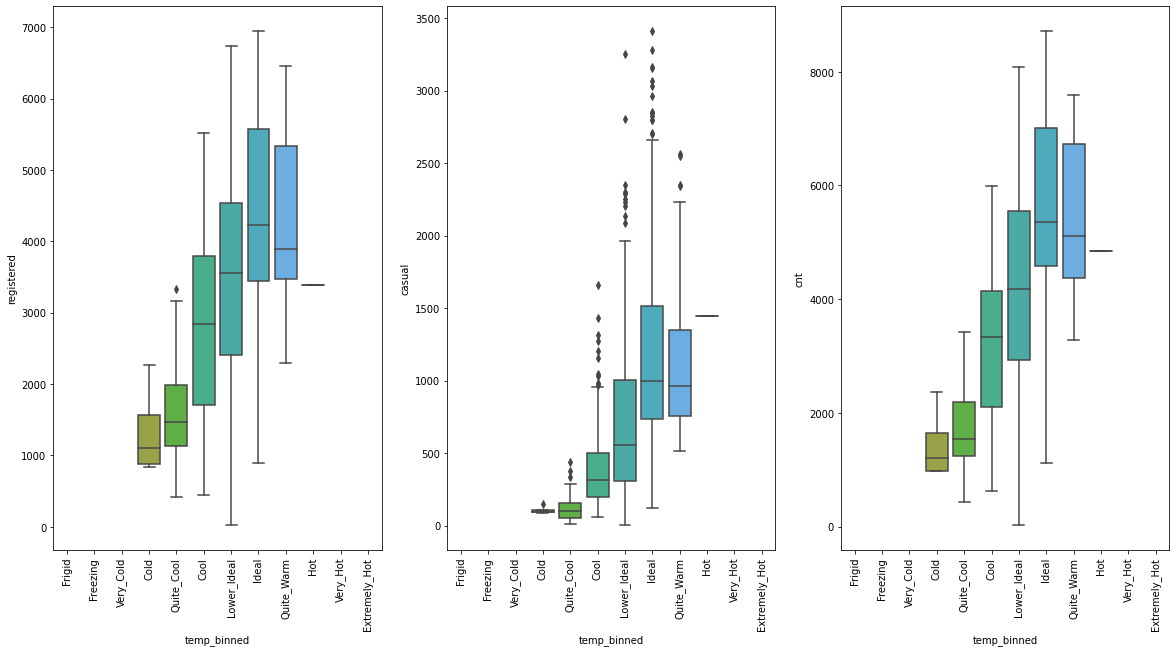

In [27]:
#plotting data for comparative analysis
plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
sns.boxplot(x = 'temp_binned', y = 'registered', data = df_bikeshare)
plt.xticks(rotation='vertical')
plt.subplot(1,3,2)
sns.boxplot(x = 'temp_binned', y = 'casual', data = df_bikeshare)
plt.xticks(rotation='vertical')
plt.subplot(1,3,3)
sns.boxplot(x = 'temp_binned', y = 'cnt', data = df_bikeshare)
plt.xticks(rotation='vertical')
plt.show()

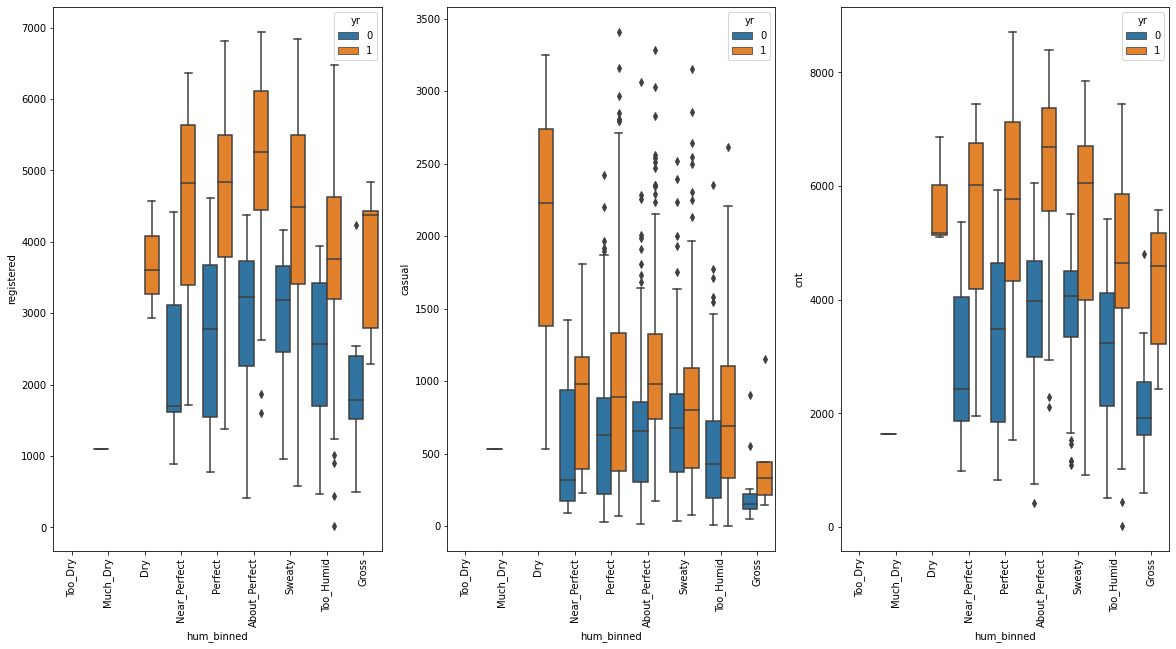

In [28]:
#plotting data for comparative analysis
plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
sns.boxplot(x = 'hum_binned', y = 'registered', hue = 'yr', data = df_bikeshare)
plt.xticks(rotation='vertical')
plt.subplot(1,3,2)
sns.boxplot(x = 'hum_binned', y = 'casual', hue = 'yr', data = df_bikeshare)
plt.xticks(rotation='vertical')
plt.subplot(1,3,3)
sns.boxplot(x = 'hum_binned', y = 'cnt', hue = 'yr', data = df_bikeshare)
plt.xticks(rotation='vertical')
plt.show()

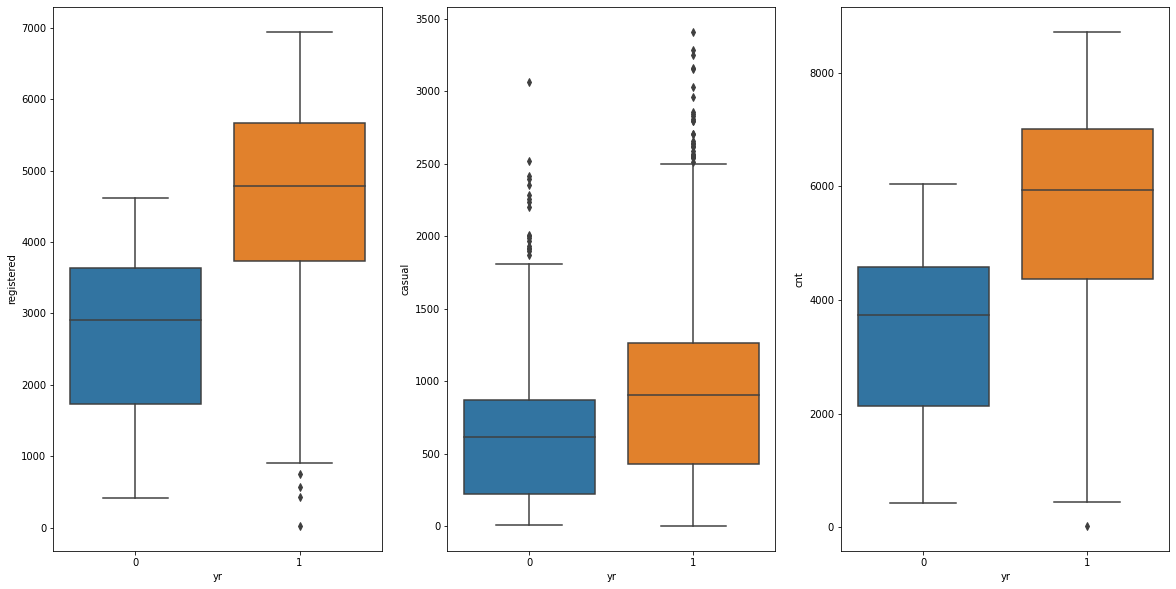

In [29]:
#plotting data for comparative analysis
plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
sns.boxplot(x = 'yr', y = 'registered', data = df_bikeshare)
plt.subplot(1,3,2)
sns.boxplot(x = 'yr', y = 'casual', data = df_bikeshare)
plt.subplot(1,3,3)
sns.boxplot(x = 'yr', y = 'cnt', data = df_bikeshare)
plt.show()

In [30]:
#plot chart per day to find specific days where surge can be expected

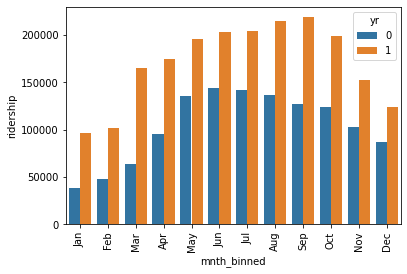

In [31]:
#plot variation across months
# perform groupby
df = df_bikeshare.groupby(['mnth_binned','yr']).agg(ridership=("cnt", 'sum'))
df = df.reset_index()
  
# plot barplot
sns.barplot(x="mnth_binned",y="ridership",hue="yr",data=df)
plt.xticks(rotation='vertical')
plt.show()

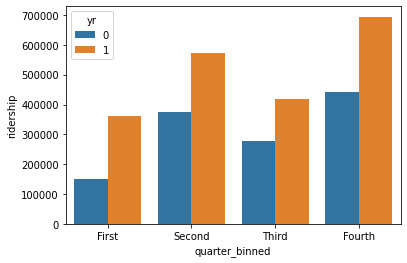

In [32]:
#plot variation across quarters
# perform groupby
df = df_bikeshare.groupby(['quarter_binned','yr']).agg(ridership=("cnt", 'sum'))
df = df.reset_index()
  
# plot barplot
sns.barplot(x="quarter_binned",y="ridership",hue='yr',data=df)

plt.show()

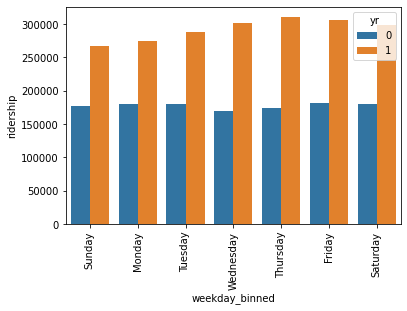

In [33]:
#plot variation across weekdays
# perform groupby
df = df_bikeshare.groupby(['weekday_binned','yr']).agg(ridership=("cnt", 'sum'))
df = df.reset_index()
  
# plot barplot
sns.barplot(x="weekday_binned",y="ridership",hue='yr',data=df)
plt.xticks(rotation='vertical')
plt.show()

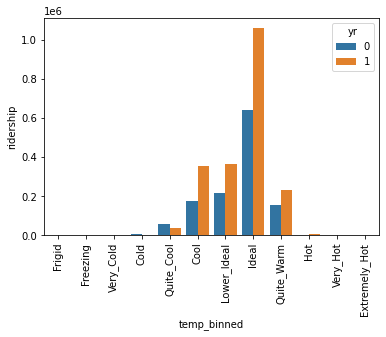

In [34]:
#plot variation across temperature conditions
# perform groupby
df = df_bikeshare.groupby(['temp_binned','yr']).agg(ridership=("cnt", 'sum'))
df = df.reset_index()
  
# plot barplot
sns.barplot(x="temp_binned",y="ridership",hue='yr',data=df)
plt.xticks(rotation='vertical')
plt.show()

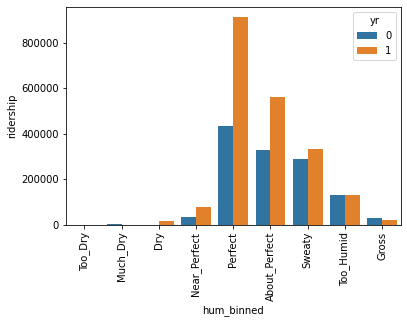

In [35]:
#plot variation across humidity conditions
# perform groupby
df = df_bikeshare.groupby(['hum_binned','yr']).agg(ridership=("cnt", 'sum'))
df = df.reset_index()
  
# plot barplot
sns.barplot(x="hum_binned",y="ridership",hue='yr',data=df)
plt.xticks(rotation='vertical')
plt.show()

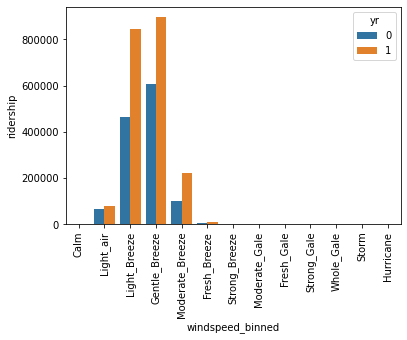

In [36]:
#plot variation across wind conditions
# perform groupby
df = df_bikeshare.groupby(['windspeed_binned','yr']).agg(ridership=("cnt", 'sum'))
df = df.reset_index()
  
# plot barplot
sns.barplot(x="windspeed_binned",y="ridership",hue='yr',data=df)
plt.xticks(rotation='vertical')
plt.show()

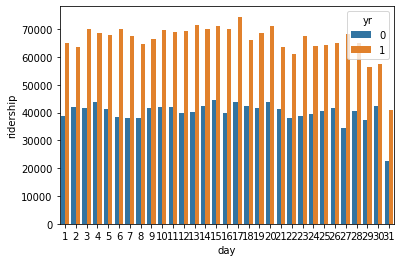

In [37]:
#plot variation across day
# perform groupby
df = df_bikeshare.groupby(['day','yr']).agg(ridership=("cnt", 'sum'))
df = df.reset_index()
  
#plot barplot
sns.barplot(x="day",y="ridership",hue='yr',data=df)

plt.show()

In [38]:
print(df_bikeshare.nunique())

instant              730
dteday               730
season                 4
yr                     2
mnth                  12
weekday                7
workingday             2
weathersit             3
temp                 498
atemp                689
hum                  594
windspeed            649
casual               605
registered           678
cnt                  695
windspeed_binned       5
temp_binned            7
day                   31
quarter_binned         4
weekday_binned         7
hum_binned             8
mnth_binned           12
weathersit_binned      3
season_binned          4
dtype: int64


In [39]:
df_bikeshare.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt', 'windspeed_binned', 'temp_binned', 'day',
       'quarter_binned', 'weekday_binned', 'hum_binned', 'mnth_binned',
       'weathersit_binned', 'season_binned'],
      dtype='object')

### **Step 6: Creating Dummy Variables**

In [40]:
#create dummy variables for binned categorial variables
windspeed_dummy = pd.get_dummies(df_bikeshare['windspeed_binned'],drop_first=True)
temp_dummy = pd.get_dummies(df_bikeshare['temp_binned'],drop_first=True)
quarter_dummy = pd.get_dummies(df_bikeshare['quarter_binned'],drop_first=True)
weathersit_dummy = pd.get_dummies(df_bikeshare['weathersit_binned'],drop_first=True)
weekday_dummy = pd.get_dummies(df_bikeshare['weekday_binned'],drop_first=True)
hum_dummy = pd.get_dummies(df_bikeshare['hum_binned'],drop_first=True)
mnth_dummy = pd.get_dummies(df_bikeshare['mnth_binned'],drop_first=True)
season_dummy = pd.get_dummies(df_bikeshare['season_binned'],drop_first=True)

In [41]:
#drop corresponding categorical variables
#Reference: https://stackoverflow.com/questions/19071199/drop-columns-whose-name-contains-a-specific-string-from-pandas-dataframe
df_bikeshare.drop(list(df_bikeshare.filter(regex = 'binned')), axis = 1, inplace = True)

In [42]:
#check dataframe for columns deletion
df_bikeshare.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt', 'day'],
      dtype='object')

In [43]:
#check variables
print(windspeed_dummy.nunique())
print(temp_dummy.nunique())
print(quarter_dummy.nunique())
print(weathersit_dummy.nunique())
print(weekday_dummy.nunique())
print(hum_dummy.nunique())
print(mnth_dummy.nunique())
print(season_dummy.nunique())

Light_air          2
Light_Breeze       2
Gentle_Breeze      2
Moderate_Breeze    2
Fresh_Breeze       2
Strong_Breeze      1
Moderate_Gale      1
Fresh_Gale         1
Strong_Gale        1
Whole_Gale         1
Storm              1
Hurricane          1
dtype: int64
Freezing         1
Very_Cold        1
Cold             2
Quite_Cool       2
Cool             2
Lower_Ideal      2
Ideal            2
Quite_Warm       2
Hot              2
Very_Hot         1
Extremely_Hot    1
dtype: int64
Second    2
Third     2
Fourth    2
dtype: int64
Cloudy            2
Light_RainSnow    2
Heavy_RainSnow    1
dtype: int64
Monday       2
Tuesday      2
Wednesday    2
Thursday     2
Friday       2
Saturday     2
dtype: int64
Much_Dry         2
Dry              2
Near_Perfect     2
Perfect          2
About_Perfect    2
Sweaty           2
Too_Humid        2
Gross            2
dtype: int64
Feb    2
Mar    2
Apr    2
May    2
Jun    2
Jul    2
Aug    2
Sep    2
Oct    2
Nov    2
Dec    2
dtype: int64
Summer    2

In [44]:
#concat dummy variable dataframe to the main dataframe
df_bikeshare = pd.concat([df_bikeshare, windspeed_dummy], axis = 1)
df_bikeshare = pd.concat([df_bikeshare, temp_dummy], axis = 1)
df_bikeshare = pd.concat([df_bikeshare, weathersit_dummy], axis = 1)
df_bikeshare = pd.concat([df_bikeshare, weekday_dummy], axis = 1)                         
df_bikeshare = pd.concat([df_bikeshare, hum_dummy], axis = 1)
df_bikeshare = pd.concat([df_bikeshare, mnth_dummy], axis = 1)
df_bikeshare = pd.concat([df_bikeshare, quarter_dummy], axis = 1)
df_bikeshare = pd.concat([df_bikeshare, season_dummy], axis = 1)

In [45]:
#check dataframe for columns concatenation
df_bikeshare.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt', 'day', 'Light_air', 'Light_Breeze',
       'Gentle_Breeze', 'Moderate_Breeze', 'Fresh_Breeze', 'Strong_Breeze',
       'Moderate_Gale', 'Fresh_Gale', 'Strong_Gale', 'Whole_Gale', 'Storm',
       'Hurricane', 'Freezing', 'Very_Cold', 'Cold', 'Quite_Cool', 'Cool',
       'Lower_Ideal', 'Ideal', 'Quite_Warm', 'Hot', 'Very_Hot',
       'Extremely_Hot', 'Cloudy', 'Light_RainSnow', 'Heavy_RainSnow', 'Monday',
       'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Much_Dry',
       'Dry', 'Near_Perfect', 'Perfect', 'About_Perfect', 'Sweaty',
       'Too_Humid', 'Gross', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sep', 'Oct', 'Nov', 'Dec', 'Second', 'Third', 'Fourth', 'Summer',
       'Autumn', 'Winter'],
      dtype='object')

In [46]:
#drop columns where there is no variable diversity
for col in df_bikeshare.columns:
    if len(df_bikeshare[col].unique()) == 1:
        df_bikeshare.drop(col,inplace=True,axis=1)

In [47]:
#check master dataframe
print(df_bikeshare.nunique())


instant    730
dteday     730
season       4
yr           2
mnth        12
          ... 
Third        2
Fourth       2
Summer       2
Autumn       2
Winter       2
Length: 61, dtype: int64


In [48]:
df_bikeshare.columns.tolist()

['instant',
 'dteday',
 'season',
 'yr',
 'mnth',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'casual',
 'registered',
 'cnt',
 'day',
 'Light_air',
 'Light_Breeze',
 'Gentle_Breeze',
 'Moderate_Breeze',
 'Fresh_Breeze',
 'Cold',
 'Quite_Cool',
 'Cool',
 'Lower_Ideal',
 'Ideal',
 'Quite_Warm',
 'Hot',
 'Cloudy',
 'Light_RainSnow',
 'Monday',
 'Tuesday',
 'Wednesday',
 'Thursday',
 'Friday',
 'Saturday',
 'Much_Dry',
 'Dry',
 'Near_Perfect',
 'Perfect',
 'About_Perfect',
 'Sweaty',
 'Too_Humid',
 'Gross',
 'Feb',
 'Mar',
 'Apr',
 'May',
 'Jun',
 'Jul',
 'Aug',
 'Sep',
 'Oct',
 'Nov',
 'Dec',
 'Second',
 'Third',
 'Fourth',
 'Summer',
 'Autumn',
 'Winter']

In [49]:
#drop original categorical and redundant columns
df_bikeshare.drop(['instant',
 'dteday',
 'season',
 'mnth',
 'weekday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'casual',
 'registered'], axis = 1, inplace = True)
df_bikeshare.head(10)

,yr,workingday,cnt,day,Light_air,Light_Breeze,Gentle_Breeze,Moderate_Breeze,Fresh_Breeze,Cold,...,Sep,Oct,Nov,Dec,Second,Third,Fourth,Summer,Autumn,Winter
0,0,0,985,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,801,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1349,3,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,1562,4,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1600,5,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,1,1606,6,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,1,1510,7,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,959,8,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,822,9,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,1,1321,10,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### **Step 7: Splitting and Scaling data**

In [50]:
#check dataframe
print(df_bikeshare.nunique())

yr                   2
workingday           2
cnt                695
day                 31
Light_air            2
Light_Breeze         2
Gentle_Breeze        2
Moderate_Breeze      2
Fresh_Breeze         2
Cold                 2
Quite_Cool           2
Cool                 2
Lower_Ideal          2
Ideal                2
Quite_Warm           2
Hot                  2
Cloudy               2
Light_RainSnow       2
Monday               2
Tuesday              2
Wednesday            2
Thursday             2
Friday               2
Saturday             2
Much_Dry             2
Dry                  2
Near_Perfect         2
Perfect              2
About_Perfect        2
Sweaty               2
Too_Humid            2
Gross                2
Feb                  2
Mar                  2
Apr                  2
May                  2
Jun                  2
Jul                  2
Aug                  2
Sep                  2
Oct                  2
Nov                  2
Dec                  2
Second     

In [51]:
## before we split the data we are going to copy the data in three dataframes for 3 modelling strategies

#copy dataframe
s1_df=df_bikeshare.copy()
# s2_df=df_bikeshare.copy()
# s3_df=df_bikeshare.copy()

In [52]:
#splitting data
# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(564)
s1_train, s1_test = train_test_split(s1_df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [53]:
s1_train.columns

Index(['yr', 'workingday', 'cnt', 'day', 'Light_air', 'Light_Breeze',
       'Gentle_Breeze', 'Moderate_Breeze', 'Fresh_Breeze', 'Cold',
       'Quite_Cool', 'Cool', 'Lower_Ideal', 'Ideal', 'Quite_Warm', 'Hot',
       'Cloudy', 'Light_RainSnow', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Much_Dry', 'Dry', 'Near_Perfect',
       'Perfect', 'About_Perfect', 'Sweaty', 'Too_Humid', 'Gross', 'Feb',
       'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec',
       'Second', 'Third', 'Fourth', 'Summer', 'Autumn', 'Winter'],
      dtype='object')

In [54]:
#set up scaler
scaler = MinMaxScaler()
# Apply scaler() to all the columns except  'cnt' variable
num_vars=s1_train.columns.tolist()
num_vars.remove('cnt')
s1_train[num_vars] = scaler.fit_transform(s1_train[num_vars])

In [55]:
s1_train.head(10)

,yr,workingday,cnt,day,Light_air,Light_Breeze,Gentle_Breeze,Moderate_Breeze,Fresh_Breeze,Cold,...,Sep,Oct,Nov,Dec,Second,Third,Fourth,Summer,Autumn,Winter
653,1.0,1.0,7534,0.500000,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
576,1.0,1.0,7216,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
426,1.0,0.0,4066,0.066667,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
728,1.0,0.0,1796,0.966667,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
482,1.0,0.0,4220,0.900000,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
111,0.0,1.0,1683,0.700000,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
580,1.0,0.0,6824,0.100000,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
500,1.0,1.0,7424,0.500000,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
479,1.0,1.0,6196,0.800000,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
472,1.0,1.0,4367,0.566667,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


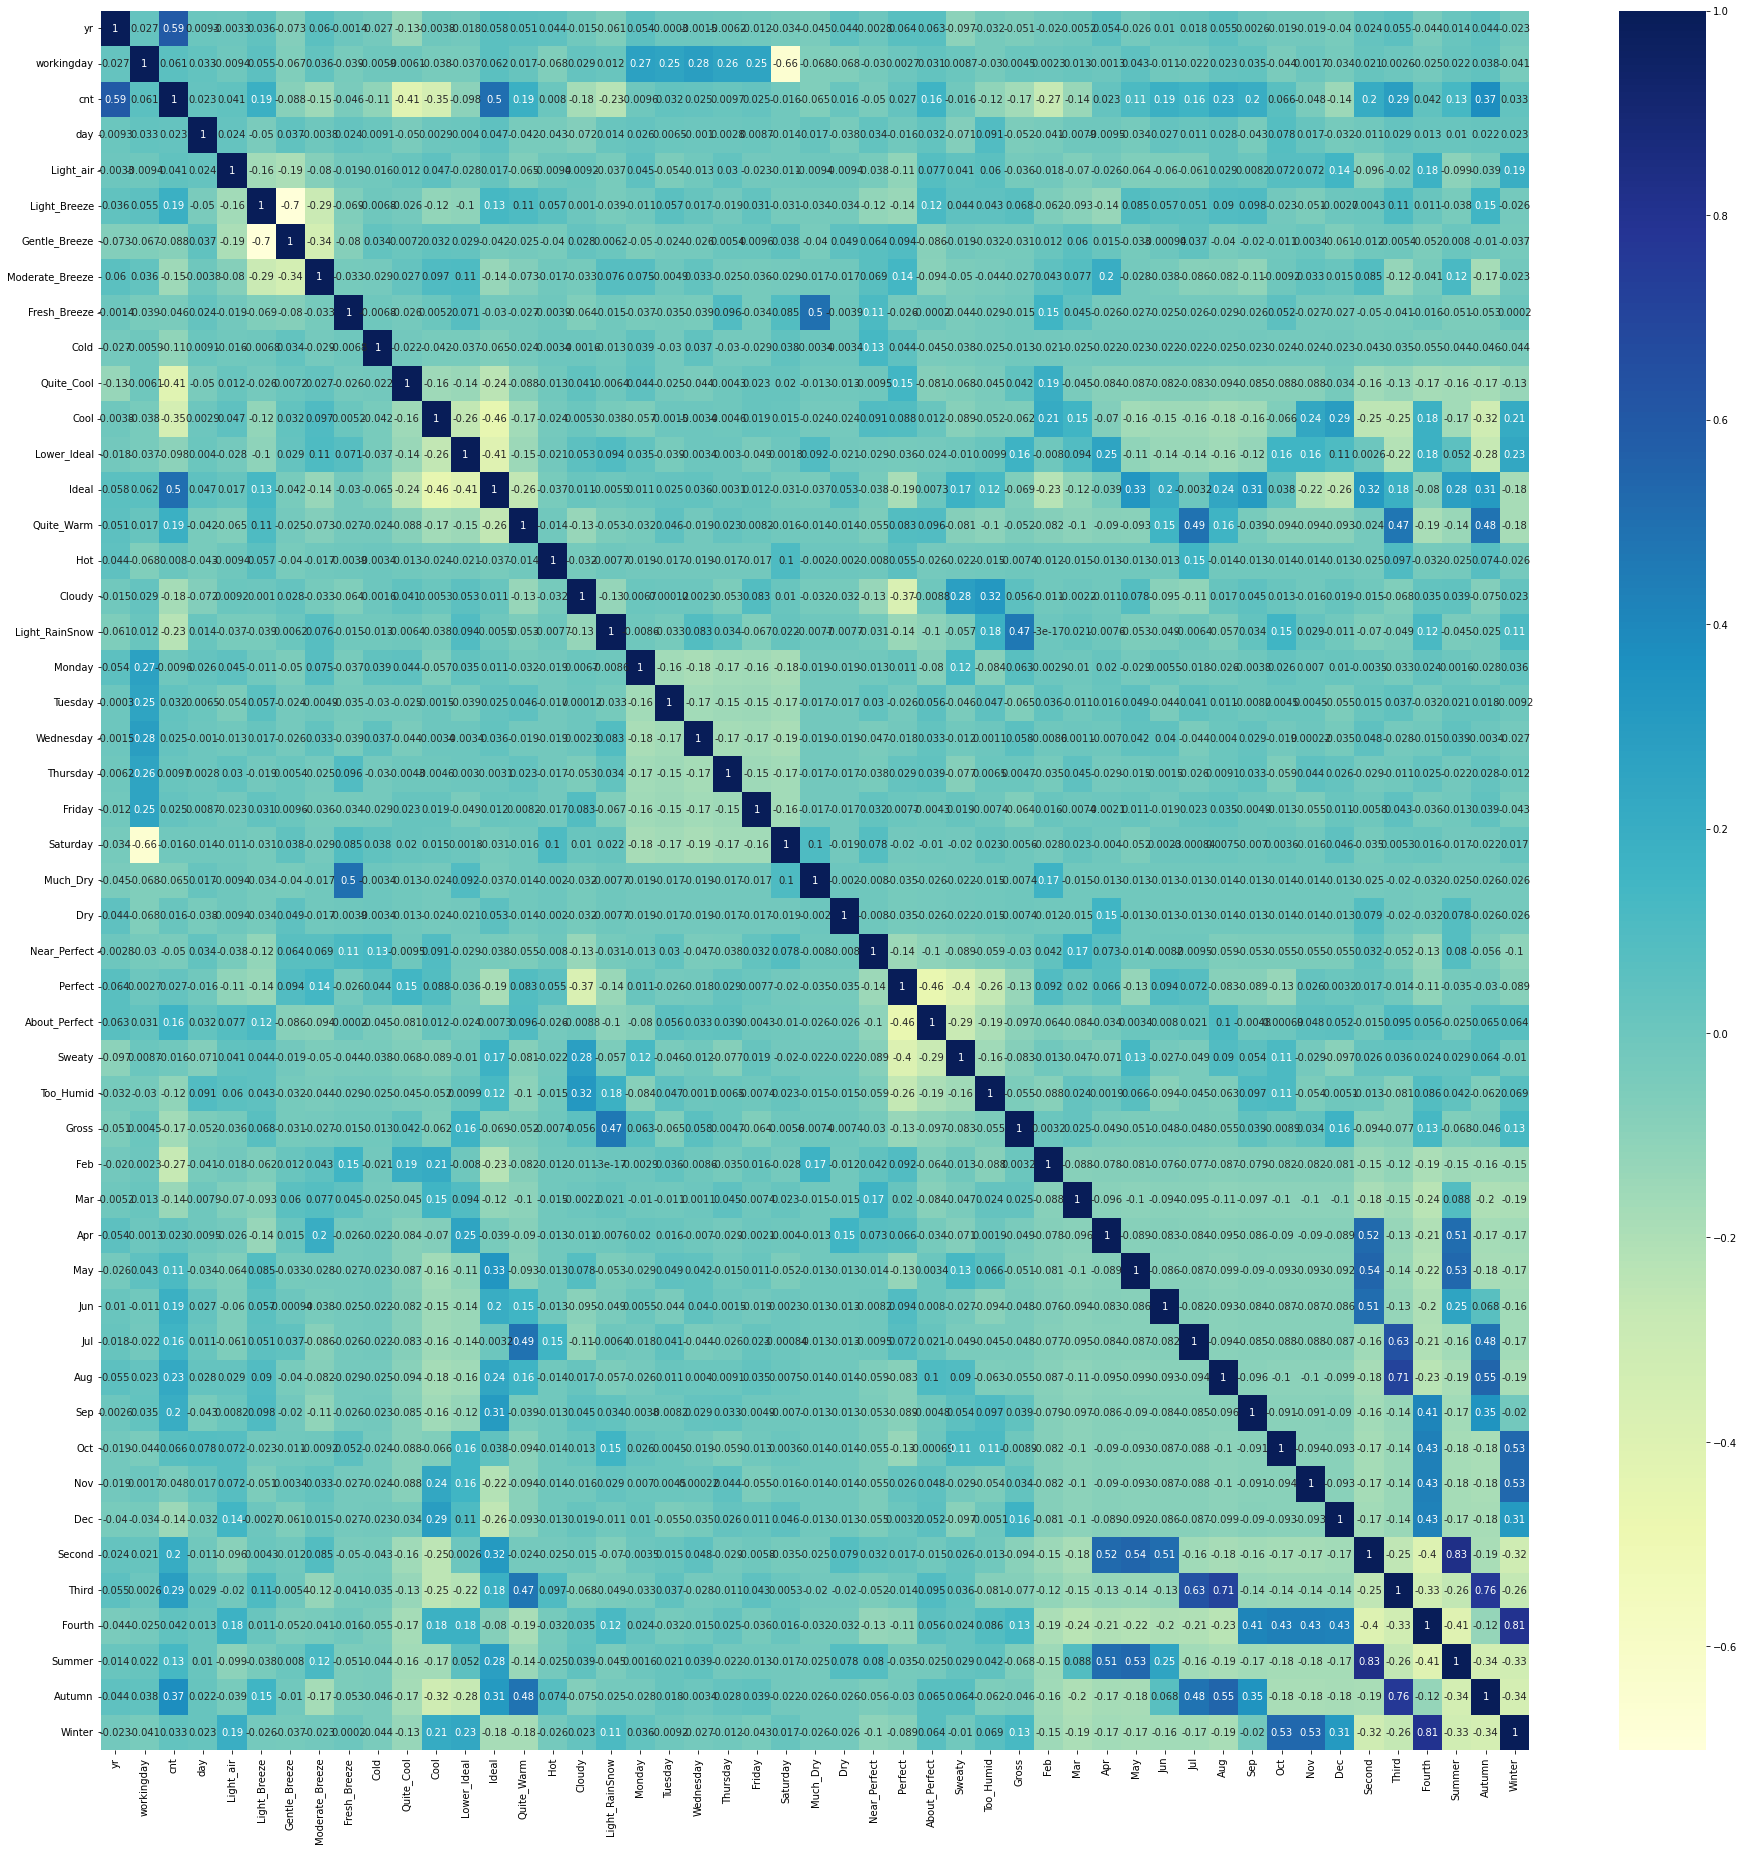

In [56]:
# Checking the correlation coefficients to see which variables are highly correlated

plt.figure(figsize = (32, 32))
sns.heatmap(s1_train.corr(), annot = True, cmap="YlGnBu")
plt.show()

In [57]:
#check column dtypes
s1_train.corr()

,yr,workingday,cnt,day,Light_air,Light_Breeze,Gentle_Breeze,Moderate_Breeze,Fresh_Breeze,Cold,...,Sep,Oct,Nov,Dec,Second,Third,Fourth,Summer,Autumn,Winter
yr,1.000000,0.027372,0.591508,0.009284,-0.003331,0.036380,-0.073301,0.059668,-0.001395,-0.026851,...,0.002574,-0.018790,-0.018790,-0.040049,0.023519,0.055114,-0.044375,0.013856,0.044102,-0.022638
workingday,0.027372,1.000000,0.061358,0.032926,-0.009350,0.055065,-0.066786,0.036172,-0.039258,-0.005936,...,0.034995,-0.044068,0.001736,-0.033700,0.020787,0.002580,-0.024820,0.022472,0.038349,-0.041129
cnt,0.591508,0.061358,1.000000,0.023184,0.040953,0.186689,-0.088091,-0.154787,-0.045607,-0.114307,...,0.201327,0.065692,-0.048130,-0.143598,0.204302,0.288212,0.041820,0.134343,0.371606,0.032636
day,0.009284,0.032926,0.023184,1.000000,0.024422,-0.049541,0.036561,-0.003797,0.023864,0.009110,...,-0.043121,0.077761,0.017278,-0.032059,-0.011022,0.029179,0.012800,0.010400,0.021928,0.022979
Light_air,-0.003331,-0.009350,0.040953,0.024422,1.000000,-0.164983,-0.191675,-0.079711,-0.018878,-0.016333,...,0.008213,0.072253,0.072253,0.143976,-0.095731,-0.020333,0.175159,-0.098547,-0.039041,0.190181
Light_Breeze,0.036380,0.055065,0.186689,-0.049541,-0.164983,1.000000,-0.701458,-0.291712,-0.069086,-0.006849,...,0.097711,-0.022554,-0.051382,-0.002742,0.004253,0.105719,0.010675,-0.038187,0.152207,-0.026314
Gentle_Breeze,-0.073301,-0.066786,-0.088091,0.036561,-0.191675,-0.701458,1.000000,-0.338907,-0.080264,0.033660,...,-0.020440,-0.010627,0.003414,-0.061118,-0.012338,-0.005360,-0.051959,0.007997,-0.010467,-0.036696
Moderate_Breeze,0.059668,0.036172,-0.154787,-0.003797,-0.079711,-0.291712,-0.338907,1.000000,-0.033379,-0.028878,...,-0.111000,-0.009239,0.033209,0.014760,0.084790,-0.124124,-0.040927,0.118570,-0.169959,-0.023264
Fresh_Breeze,-0.001395,-0.039258,-0.045607,0.023864,-0.018878,-0.069086,-0.080264,-0.033379,1.000000,-0.006839,...,-0.026288,0.051847,-0.027320,-0.026979,-0.049588,-0.040601,-0.016409,-0.050662,-0.053078,0.000202
Cold,-0.026851,-0.005936,-0.114307,0.009110,-0.016333,-0.006849,0.033660,-0.028878,-0.006839,1.000000,...,-0.022744,-0.023637,-0.023637,-0.023342,-0.042902,-0.035127,-0.054873,-0.043831,-0.045921,-0.044295


###### **Checking for Multicollinearity using recursive method**

#### Splitting into sub set

In [58]:
y_train = s1_train.pop('cnt')
X_train = s1_train

### Step 8: Building a linear regression model

***Function to Undertake Recursive VIF analysis of a dataframe***

In [59]:
##reference: https://www.geeksforgeeks.org/multicollinearity-in-data/
def recursive_VIF(X_df,y_df):
    #create a test dataframe
    vif_df=X_df.copy()
    #empty list to hold results
    dropped_features=[]
    selected_features=[]
    dropped_VIF_df=pd.DataFrame(columns=['Feature', 'VIF_Value'])
    #shuffle the column ordering
    #import random
    #column_shuffle=vif_df.columns.tolist() #convert pandas index to list
    #random.shuffle(column_shuffle) #shuffle list
    #shuffle dataframe columns
    #set_column_sequence(vif_df, column_shuffle, front=True) #not required
    Y = y_df
    features = vif_df.columns
    X = vif_df[features]
    #reference: https://github.com/statsmodels/statsmodels/issues/2376
    #add constant prior calculating VIF
    X = sm.add_constant(X)
    # calculate the variance inflation factor
    from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
     # compare with each column
    [vif(vif_df[features].values, index) for index in range(len(features))]
    # compare with each columns
    for i in range(len(features)):
        vif_list = [vif(vif_df[features].values, index) for index in range(len(features))]
        maxvif = max(vif_list)
        drop_index = vif_list.index(maxvif)
        dropped_VIF_df.loc[len(dropped_VIF_df.index)] = [features[drop_index], maxvif]
        #print("Max VIF value is {} for independent variable {} at index {}.".format(maxvif,features[drop_index],drop_index))  
        if maxvif > 4.99:
            #print("Deleting", features[drop_index])
            dropped_features.append(features[drop_index])
            features = features.delete(drop_index)
    #print("Final Independent_variables are {}\n".format(features))
    selected_features=features
    return dropped_features,selected_features,dropped_VIF_df

In [60]:
VIF_drop,VIF_select,dropped_VIF_df=recursive_VIF(X_train,y_train)

In [61]:
#print (dropped_VIF_df)

### ***Adding Variables that are correlated based on VIF analysis***

##### ***Extracting Results from regression model***

In [62]:
#References:-
#https://stackoverflow.com/questions/48522609/how-to-retrieve-model-estimates-from-statsmodels
#https://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.RegressionResults.html
#https://stackoverflow.com/questions/37508158/how-to-extract-a-particular-value-from-the-ols-summary-in-pandas
#https://gist.github.com/zhiyzuo/972b8b95e115c44d6805c929b7b4e2ca
#https://stackoverflow.com/questions/47388258/how-to-extract-the-regression-coefficient-from-statsmodels-api
#https://stackoverflow.com/questions/51734180/converting-statsmodels-summary-object-to-pandas-dataframe/52976810

#### ***Function for comparative analysis with RFE***

In [63]:
def RFE_compare(X_df,y_df,features2compare):
    lm = LinearRegression()
    lm.fit(X_df, y_df)
     #for starts limit the no of features selected to that gereated in recursive VIF
    rfe = RFE(lm, n_features_to_select=len(features2compare))
    rfe = rfe.fit(X_df, y_df)
    list(zip(X_df.columns,rfe.support_,rfe.ranking_))
    support_col = X_df.columns[rfe.support_]
    unsuport_col=X_df.columns[~rfe.support_]
    #get common columns between features2compare and RFE top features
    RFE_list=features2compare
    common_features=list(set(feature_list) & set(RFE_list))
    #get diffirece if features
    feature_rejected=list(set(X_df.columns.tolist())-set(feature_list))
    RFE_rejected=X_df.columns[~rfe.support_]
    common_rejected=list(set(feature_rejected) & set(RFE_rejected))
    return common_features,common_rejected

In [64]:
 #Obtain regression model coefficients from statsmodels 
 #Reference: https://gist.github.com/zhiyzuo/972b8b95e115c44d6805c929b7b4e2ca
def get_coef_table(lin_reg):
    ''' lin_reg is a fitted statsmodels regression model
    Return a dataframe containing coefficients, pvalues, and the confidence intervals
    '''
    err_series = lin_reg.params - lin_reg.conf_int()[0]
    coef_df = pd.DataFrame({'coef': lin_reg.params.values[1:],
                            'ci_err': err_series.values[1:],
                            'pvalue': lin_reg.pvalues.round(4).values[1:],
                            'varname': err_series.index.values[1:]
                           })
    return coef_df

In [65]:
def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"pvals":pvals,
                               "coeff":coeff,
                               "conf_lower":conf_lower,
                               "conf_higher":conf_higher
                                })

    #Reordering...
    results_df = results_df[["coeff","pvals","conf_lower","conf_higher"]]
    return results_df

In [66]:
#create a function to undertake linear_regression and undertake analysis
def linear_regression(df_indices,df_Xtrain,df_ytrain):
    #undertake regression
    X_train_lm = df_Xtrain[df_indices]
    X_train_lm = sm.add_constant(X_train_lm)
    lr_results = sm.OLS(df_ytrain, X_train_lm).fit() #create model
    #calculate VIF
    vif = pd.DataFrame()
    vif['varname'] = X_train_lm.columns
    vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False) 
    vif=vif.set_index('varname')#change df index to varname
    #process lr summary results
    df_lr_sum=get_coef_table(lr_results)#This works better :-)!
    df_lr_sum.set_index('varname')#change df index to varname
    df_lr_sum = df_lr_sum.sort_values(by=['pvalue'], ascending=False)#sort the dataframe by p value and in descending order
    #to undertake holistic analysis look at VIF and P values
    lr_sum=df_lr_sum.merge(vif, on='varname', how='left')#join both dataframes 
    lr_sum=lr_sum.set_index('varname')
    return lr_results, vif, lr_sum

In [67]:
def iterate_recursion(feature_index,Xtrain,ytrain):
    lr,vif,lr_summary =linear_regression(feature_index,Xtrain,ytrain)
    print ("Length of index is {}\n\r".format(len(feature_index)))
    lr_summary.sort_values(by=['VIF'], ascending=False, inplace=True)#sort the dataframe by vif and in descending order
    ##testing recursive modelling to save time
    lr_summary=lr_summary.reset_index()
    print(lr_summary)
    top_feature=lr_summary.varname.iloc[0]
    feature_pvalue=lr_summary.pvalue.iloc[0]
    feature_vif=lr_summary.VIF.iloc[0]
    if (feature_vif>=4):
        print("VIF of {} is {}(>4)".format(top_feature,feature_vif))
        print("dropping feature {} and redoing regression..".format(top_feature))
        #drop feature from index
        feature_index=feature_index.drop(top_feature)
        #recurse regression
        lr,vif,lr_summary,feature_index=iterate_recursion(feature_index,Xtrain,ytrain)
    
    lr_summary.sort_values(by=['pvalue'], ascending=False, inplace=True)#sort the dataframe by vif and in descending order
    ##testing recursive modelling to save time
    top_feature=lr_summary.varname.iloc[0]
    feature_pvalue=lr_summary.pvalue.iloc[0]
    if (feature_pvalue>=0.05):
        print("p value of {} is {}(>0.05)".format(top_feature,feature_pvalue))
        print("dropping feature {} and redoing regression..".format(top_feature))
        #drop feature from index
        feature_index=feature_index.drop(top_feature)
        #recurse regression
        lr,vif,lr_summary,feature_index=iterate_recursion(feature_index,Xtrain,ytrain)
    print ("Final feature count is {}".format(len(feature_index)))
    return lr,vif,lr_summary,feature_index



In [68]:
iv=s1_train.columns
regression_summary,VIF,feature_summary,feature_list =iterate_recursion(iv,X_train,y_train)
print (VIF)

Length of index is 48

            varname         coef       ci_err  pvalue     VIF
0               Jun   228.638970   275.078664  0.1031     inf
1        Quite_Cool  -493.272521   396.566330  0.0149     inf
2         Wednesday   159.341100   150.920888  0.0386     inf
3     Gentle_Breeze   302.645681   295.791126  0.0449     inf
4            Friday   166.527791   165.070041  0.0480     inf
5            Monday  -154.261291   156.312858  0.0531     inf
6              Cold  -812.481545   828.347604  0.0545     inf
7            Second   397.215077   412.054824  0.0588     inf
8               Sep   550.172329   378.300631  0.0045     inf
9               Dec  -181.197469   233.089972  0.1273     inf
10            Third   338.491423   440.820191  0.1320     inf
11              Hot  -975.520810  1327.379067  0.1494     inf
12       workingday   257.580019   159.109273  0.0016     inf
13              Jul   173.481692   282.977759  0.2289     inf
14              Aug   165.009730   269.598814  

Length of index is 45

            varname         coef       ci_err  pvalue     VIF
0          Thursday    69.031062   164.477718  0.4099     inf
1      Light_Breeze   530.577864   299.497895  0.0005     inf
2            Friday   166.527791   165.070041  0.0480     inf
3            Monday  -154.261291   156.312858  0.0531     inf
4              Cold  -812.481545   828.347604  0.0545     inf
5         Wednesday   159.341100   150.920888  0.0386     inf
6               Hot  -975.520810  1327.379067  0.1494     inf
7        Quite_Cool  -493.272521   396.566330  0.0149     inf
8        workingday   257.580019   159.109273  0.0016     inf
9      Fresh_Breeze  -370.414283   765.239069  0.3420     inf
10        Light_air   658.172397   385.735179  0.0009     inf
11             Cool  -159.623804   336.621586  0.3519     inf
12    Gentle_Breeze   302.645681   295.791126  0.0449     inf
13  Moderate_Breeze  -130.547648   338.104402  0.4484     inf
14       Quite_Warm  1109.103222   410.204287  

Length of index is 42

            varname         coef       ci_err  pvalue     VIF
0           Perfect   287.782730  1579.949782  0.7206  144.75
1     About_Perfect   202.241238  1578.920516  0.8014  114.21
2            Sweaty   -68.680668  1577.110955  0.9318   95.55
3         Too_Humid  -485.900265  1565.808226  0.5423   52.84
4      Near_Perfect   165.185257  1625.052622  0.8418   19.56
5            Second   625.854047   609.475901  0.0442   16.38
6             Gross  -400.105120  1556.597988  0.6137   15.76
7            Fourth   -69.936952   480.023613  0.7748   12.55
8            Autumn  1024.368980   497.761333  0.0001   11.70
9             Ideal  2120.027344   436.878600  0.0000   11.30
10              Aug   503.501153   673.747363  0.1426    9.61
11           Winter  1679.912355   427.106448  0.0000    8.31
12              Jul   511.973115   690.010279  0.1455    8.19
13           Summer   763.639128   391.327501  0.0001    6.91
14      Lower_Ideal  1188.747167   377.420995  

Length of index is 38

            varname         coef       ci_err  pvalue   VIF
0             Ideal  2745.981422   347.794523  0.0000  6.66
1            Winter  1161.010356   304.599669  0.0000  3.93
2            Summer   672.302020   305.859477  0.0000  3.92
3       Lower_Ideal  1528.550048   334.037706  0.0000  3.86
4              Cool   563.071065   306.776083  0.0003  3.72
5        workingday   300.343728   259.321365  0.0233  3.19
6        Quite_Warm  2462.836275   420.763179  0.0000  3.16
7               Oct   121.078274   373.865659  0.5248  2.50
8               Apr     1.248260   378.228406  0.9948  2.34
9               May   -76.241201   353.939657  0.6723  2.19
10              Nov   -64.920954   345.828533  0.7124  2.14
11              Jul   670.810843   363.708223  0.0003  2.12
12              Aug   756.827735   327.199877  0.0000  2.11
13           Monday  -216.664487   257.368238  0.0987  1.92
14        Wednesday   102.511567   250.059307  0.4209  1.89
15         Saturd

Length of index is 33

            varname         coef       ci_err  pvalue   VIF
0            Winter  1380.280559   369.699014  0.0000  3.87
1            Summer  1587.541900   344.336478  0.0000  3.32
2        workingday   362.189573   316.513373  0.0250  3.18
3               Oct   721.963258   444.913167  0.0015  2.36
4               Apr  -125.540426   460.244040  0.5922  2.32
5               May   243.337288   428.558619  0.2651  2.15
6               Nov   168.327500   420.697928  0.4321  2.11
7              Cool -1125.667941   268.444437  0.0000  1.91
8            Monday  -277.265426   313.691656  0.0831  1.91
9         Wednesday   126.145277   305.336041  0.4173  1.89
10         Saturday   404.297388   304.604889  0.0094  1.84
11              Jul  1763.034344   410.205546  0.0000  1.80
12          Tuesday   -71.877616   321.499672  0.6606  1.79
13           Friday    72.429015   324.054723  0.6607  1.77
14      Lower_Ideal  -425.906473   273.351597  0.0023  1.73
15              A

Length of index is 29

            varname         coef       ci_err  pvalue   VIF
0            Winter  1395.741034   360.726139  0.0000  3.71
1        workingday   396.308245   271.999014  0.0044  2.36
2               Oct   721.059243   442.201920  0.0014  2.35
3            Summer  1529.382692   276.873358  0.0000  2.16
4               Nov   166.108761   417.773496  0.4350  2.10
5              Cool -1139.171177   263.830085  0.0000  1.85
6          Saturday   403.767398   303.418521  0.0092  1.84
7               May   296.224877   369.150765  0.1155  1.61
8               Aug  1955.429761   348.724769  0.0000  1.61
9    Light_RainSnow -2359.803076   605.123635  0.0000  1.59
10            Gross  -518.807751   621.528423  0.1016  1.57
11      Lower_Ideal  -452.856855   259.008185  0.0006  1.56
12              Jul  1795.575790   375.350278  0.0000  1.52
13        Too_Humid  -583.931852   330.996612  0.0006  1.48
14           Cloudy  -714.172462   206.526502  0.0000  1.47
15              S

            varname         coef       ci_err  pvalue   VIF
0            Winter  1528.295491   270.259998  0.0000  2.09
1            Summer  1547.790726   262.780608  0.0000  1.95
2        workingday   418.958704   243.198183  0.0008  1.89
3          Saturday   422.574073   301.385073  0.0061  1.82
4              Cool -1149.396899   259.041321  0.0000  1.79
5               Oct   598.925816   367.007519  0.0014  1.62
6               May   288.537249   363.974752  0.1200  1.56
7    Light_RainSnow -2362.697017   595.757243  0.0000  1.55
8       Lower_Ideal  -447.885035   257.076534  0.0007  1.54
9               Aug  1976.337813   335.956362  0.0000  1.50
10            Gross  -484.021727   603.979418  0.1160  1.49
11              Jul  1820.925685   363.863959  0.0000  1.43
12              Sep  2033.460716   348.343616  0.0000  1.37
13        Too_Humid  -538.983297   309.549034  0.0007  1.29
14  Moderate_Breeze  -769.305439   277.971347  0.0000  1.28
15           Cloudy  -750.003930   190.4

### ***Undertake a comparative feature analysis with RFE***

In [69]:
fea2comp=VIF.index.tolist()
feature_common,feature_rejected=RFE_compare(X_train,y_train,fea2comp)
print ("Common features are:{}".format(feature_common))
print ("UnCommon features are:{}".format(feature_rejected))

Common features are:['Lower_Ideal', 'Oct', 'Winter', 'Hot', 'yr', 'Cloudy', 'Aug', 'Jul', 'Monday', 'Too_Humid', 'Gentle_Breeze', 'Cold', 'Saturday', 'Light_RainSnow', 'Sep', 'workingday', 'Summer', 'Cool', 'Mar', 'Moderate_Breeze']
UnCommon features are:['Ideal', 'Dry', 'Near_Perfect', 'Light_air', 'Much_Dry', 'Feb', 'Sweaty', 'Quite_Warm', 'Autumn', 'About_Perfect', 'day', 'Quite_Cool', 'Fresh_Breeze', 'Perfect', 'Gross']


In [70]:
regression_summary,VIF,feature_summary,feature_list =iterate_recursion(VIF_select,X_train,y_train)
fea2comp=VIF.index.tolist()
feature_common1,feature_rejected1=RFE_compare(X_train,y_train,fea2comp)
print ("Common features are:{}".format(feature_common1))
print ("UnCommon features are:{}".format(feature_rejected1))

Length of index is 36

            varname         coef       ci_err  pvalue   VIF
0             Third   101.173962   381.342668  0.6024  4.01
1              Cool -2466.341406   277.071172  0.0000  2.59
2            Summer   234.153281   256.680189  0.0737  2.36
3               Aug    49.399091   373.061027  0.7948  2.34
4       Lower_Ideal -1444.381001   260.910810  0.0000  2.01
5               May  -293.583619   359.700759  0.1094  1.93
6          Saturday   435.450857   271.094724  0.0017  1.86
7         Wednesday   404.985861   267.588233  0.0031  1.85
8            Monday   116.484419   271.888719  0.4003  1.83
9         Too_Humid  -769.561480   325.123115  0.0000  1.81
10         Thursday   294.017822   281.448604  0.0406  1.77
11              Dec   400.972859   342.028246  0.0217  1.75
12           Sweaty  -359.325072   239.156482  0.0033  1.74
13          Tuesday   266.490211   280.381002  0.0624  1.73
14           Friday   411.671062   283.119638  0.0045  1.72
15              N

Length of index is 32

            varname         coef       ci_err  pvalue   VIF
0              Cool -2465.451704   258.243901  0.0000  2.27
1            Summer   200.128017   238.331565  0.0996  2.04
2          Saturday   432.313747   269.047896  0.0017  1.84
3         Wednesday   398.600802   265.976550  0.0034  1.84
4            Monday   117.080043   270.297276  0.3951  1.82
5       Lower_Ideal -1439.021219   243.229671  0.0000  1.76
6          Thursday   289.484461   279.279258  0.0422  1.75
7           Tuesday   266.021762   278.092128  0.0608  1.72
8            Friday   413.688109   281.124651  0.0040  1.71
9               Dec   382.364709   336.780001  0.0262  1.70
10              Nov   693.458490   326.299784  0.0000  1.63
11              May  -279.052780   326.134240  0.0934  1.60
12   Light_RainSnow -2182.281357   534.240776  0.0000  1.59
13            Gross  -506.855984   550.715755  0.0712  1.58
14           Cloudy  -499.485484   185.626125  0.0000  1.51
15        Too_Hum

Length of index is 27

            varname         coef       ci_err  pvalue   VIF
0              Cool -2547.804930   237.523551  0.0000  1.92
1            Summer   175.666504   229.323762  0.1329  1.90
2       Lower_Ideal -1503.715288   231.378449  0.0000  1.59
3    Light_RainSnow -2165.852668   533.501828  0.0000  1.58
4               May  -270.563352   322.859669  0.1003  1.57
5             Gross  -530.620121   548.249908  0.0578  1.56
6               Dec   446.344603   314.359870  0.0055  1.49
7            Cloudy  -477.612266   184.013469  0.0000  1.49
8         Too_Humid  -773.185376   292.190116  0.0000  1.47
9               Nov   742.304215   304.484408  0.0000  1.42
10           Sweaty  -318.185205   212.305044  0.0034  1.38
11         Saturday   369.196642   229.913562  0.0017  1.35
12        Wednesday   339.337636   226.457724  0.0034  1.34
13       Quite_Cool -3291.693651   312.186745  0.0000  1.34
14              Feb  -315.506097   331.159495  0.0618  1.33
15         Thursd

Common features are:['Light_Breeze', 'Lower_Ideal', 'Oct', 'Friday', 'Dec', 'Wednesday', 'Nov', 'Hot', 'yr', 'Fresh_Breeze', 'Gross', 'Cloudy', 'Sweaty', 'Quite_Warm', 'Quite_Cool', 'Too_Humid', 'Cold', 'Feb', 'Saturday', 'Light_RainSnow', 'Cool', 'Moderate_Breeze']
UnCommon features are:['Ideal', 'Winter', 'Dry', 'Near_Perfect', 'Much_Dry', 'Autumn', 'Summer', 'About_Perfect', 'day', 'Mar', 'Perfect']


In [71]:
#build final fitted model
X_train_lm = X_train[feature_list]
X_train_lm = sm.add_constant(X_train_lm)
lr_final = sm.OLS(y_train, X_train_lm).fit()
y_train_cnt = lr_final.predict(X_train_lm)
lr_final.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     106.2
Date:                Sat, 09 Apr 2022   Prob (F-statistic):          5.73e-170
Time:                        16:56:06   Log-Likelihood:                -4139.2
No. Observations:                 510   AIC:                             8324.
Df Residuals:                     487   BIC:                             8422.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            4770.5734     96.729     49.319      0.000    4580.516    4960.631
yr               1992.7616     75.563     26.372      0.000    1844.291    2141.232
Light_Breeze      202.5108     81.489      2.485      0.013      42.397     362.625
Moderate_Breeze  -505.0975    119.404     -4.230      0.000    -739.708    -270.487
Fresh_Breeze    -1053.8836    428.725     -2.458      0.014   -1896.262    -211.505
Cold            -3930.3153    485.256     -8.099      0.000   -4883.769   -2976.862
Quite_Cool      -3313.7504    154.901    -21.393      0.000   -3618.108   -3009.393
Cool            -2516.5288    119.240    -21.105      0.000   -2750.817   -2282.240
Lower_Ideal     -1457.5757    115.010    -12.674      0.000   -1683.552   -1231.600
Quite_Warm       -379.1268    141.214     -2.685      0.008    -656.591    -101.663
Hot             -2401.7695    838.562     -2.864      0.004   -4049.416    -754.123
Cloudy           -464.2657     94.058     -4.936      0.000    -649.076    -279.455
Light_RainSnow  -2112.1157    272.337     -7.756      0.000   -2647.216   -1577.016
Wednesday         237.2955    105.308      2.253      0.025      30.382     444.209
Friday            249.8928    115.273      2.168      0.031      23.400     476.386
Saturday          275.9237    106.985      2.579      0.010      65.714     486.133
Sweaty           -365.3988    107.152     -3.410      0.001    -575.935    -154.862
Too_Humid        -785.6719    149.493     -5.256      0.000   -1079.402    -491.942
Gross            -595.5447    279.504     -2.131      0.034   -1144.728     -46.362
Feb              -365.8627    165.678     -2.208      0.028    -691.395     -40.330
Oct               703.2761    140.101      5.020      0.000     428.000     978.552
Nov               687.7997    148.567      4.630      0.000     395.888     979.712
Dec               385.8128    154.716      2.494      0.013      81.819     689.806
==============================================================================
Omnibus:                       53.250   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.944
Skew:                          -0.712   Prob(JB):                     2.65e-18
Kurtosis:                       4.335   Cond. No.                         31.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [72]:
#build  model based on RFE common analysis
X_train_lm_RFE_eval = X_train[feature_common]
X_train_lm_RFE_eval = sm.add_constant(X_train_lm_RFE_eval)
lr_final_RFE_eval = sm.OLS(y_train, X_train_lm_RFE_eval).fit()
y_train_cnt_RFE_eval = lr_final_RFE_eval.predict(X_train_lm_RFE_eval)
lr_final_RFE_eval.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     86.69
Date:                Sat, 09 Apr 2022   Prob (F-statistic):          1.83e-146
Time:                        16:56:06   Log-Likelihood:                -4201.2
No. Observations:                 510   AIC:                             8444.
Df Residuals:                     489   BIC:                             8533.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2657.8770    160.955     16.513      0.000    2341.627    2974.127
Lower_Ideal      -520.0896    127.935     -4.065      0.000    -771.461    -268.719
Oct               617.5026    184.080      3.355      0.001     255.817     979.188
Winter           1527.0455    136.801     11.163      0.000    1258.255    1795.836
Hot             -2225.1444    954.073     -2.332      0.020   -4099.732    -350.556
yr               2183.9060     83.642     26.110      0.000    2019.563    2348.249
Cloudy           -760.3319     94.955     -8.007      0.000    -946.901    -573.763
Aug              1978.0220    169.961     11.638      0.000    1644.078    2311.966
Jul              1822.8016    184.615      9.874      0.000    1460.065    2185.538
Monday           -347.9248    121.715     -2.859      0.004    -587.073    -108.777
Too_Humid        -474.5977    154.151     -3.079      0.002    -777.477    -171.719
Gentle_Breeze    -225.6907     90.471     -2.495      0.013    -403.450     -47.932
Cold            -1693.3386    550.774     -3.074      0.002   -2775.513    -611.164
Saturday          400.5598    153.237      2.614      0.009      99.476     701.644
Light_RainSnow  -2601.8292    259.648    -10.021      0.000   -3111.993   -2091.666
Sep              2015.9775    176.687     11.410      0.000    1668.819    2363.136
workingday        423.2785    124.089      3.411      0.001     179.466     667.091
Summer           1663.2742    121.167     13.727      0.000    1425.203    1901.345
Cool            -1167.0168    130.031     -8.975      0.000   -1422.506    -911.528
Mar               332.3229    151.276      2.197      0.029      35.092     629.554
Moderate_Breeze  -743.4942    140.244     -5.301      0.000   -1019.050    -467.939
==============================================================================
Omnibus:                       32.793   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.285
Skew:                          -0.431   Prob(JB):                     3.64e-13
Kurtosis:                       4.397   Cond. No.                         36.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
#build  model based on RFE common analysis
X_train_lm_RFE_eval1 = X_train[feature_common1]
X_train_lm_RFE_eval1 = sm.add_constant(X_train_lm_RFE_eval)
lr_final_RFE_eval1 = sm.OLS(y_train, X_train_lm_RFE_eval1).fit()
y_train_cnt_RFE_eval1 = lr_final_RFE_eval1.predict(X_train_lm_RFE_eval1)
lr_final_RFE_eval1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     86.69
Date:                Sat, 09 Apr 2022   Prob (F-statistic):          1.83e-146
Time:                        16:56:06   Log-Likelihood:                -4201.2
No. Observations:                 510   AIC:                             8444.
Df Residuals:                     489   BIC:                             8533.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2657.8770    160.955     16.513      0.000    2341.627    2974.127
Lower_Ideal      -520.0896    127.935     -4.065      0.000    -771.461    -268.719
Oct               617.5026    184.080      3.355      0.001     255.817     979.188
Winter           1527.0455    136.801     11.163      0.000    1258.255    1795.836
Hot             -2225.1444    954.073     -2.332      0.020   -4099.732    -350.556
yr               2183.9060     83.642     26.110      0.000    2019.563    2348.249
Cloudy           -760.3319     94.955     -8.007      0.000    -946.901    -573.763
Aug              1978.0220    169.961     11.638      0.000    1644.078    2311.966
Jul              1822.8016    184.615      9.874      0.000    1460.065    2185.538
Monday           -347.9248    121.715     -2.859      0.004    -587.073    -108.777
Too_Humid        -474.5977    154.151     -3.079      0.002    -777.477    -171.719
Gentle_Breeze    -225.6907     90.471     -2.495      0.013    -403.450     -47.932
Cold            -1693.3386    550.774     -3.074      0.002   -2775.513    -611.164
Saturday          400.5598    153.237      2.614      0.009      99.476     701.644
Light_RainSnow  -2601.8292    259.648    -10.021      0.000   -3111.993   -2091.666
Sep              2015.9775    176.687     11.410      0.000    1668.819    2363.136
workingday        423.2785    124.089      3.411      0.001     179.466     667.091
Summer           1663.2742    121.167     13.727      0.000    1425.203    1901.345
Cool            -1167.0168    130.031     -8.975      0.000   -1422.506    -911.528
Mar               332.3229    151.276      2.197      0.029      35.092     629.554
Moderate_Breeze  -743.4942    140.244     -5.301      0.000   -1019.050    -467.939
==============================================================================
Omnibus:                       32.793   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.285
Skew:                          -0.431   Prob(JB):                     3.64e-13
Kurtosis:                       4.397   Cond. No.                         36.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

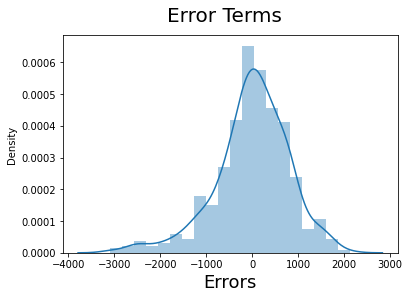

In [74]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_cnt), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label
plt.show()

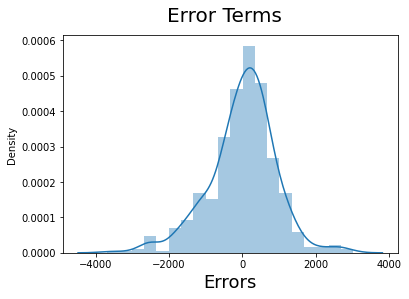

In [75]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_cnt_RFE_eval), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label
plt.show()

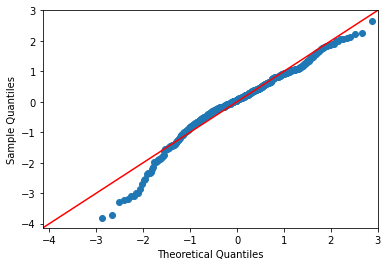

In [76]:
#Reference: https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
#           https://stats.stackexchange.com/questions/111010/interpreting-qqplot-is-there-any-rule-of-thumb-to-decide-for-non-normality/111013#111013

sm.qqplot((y_train - y_train_cnt), fit=True, line='45')
plt.show()

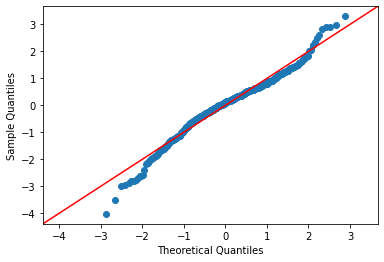

In [77]:
#Reference: https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
#           https://stats.stackexchange.com/questions/111010/interpreting-qqplot-is-there-any-rule-of-thumb-to-decide-for-non-normality/111013#111013

sm.qqplot((y_train - y_train_cnt_RFE_eval), fit=True, line='45')
plt.show()

### **Step 9: Making prediction based on model coeff.**

###### ***Scaling Test Set***

In [78]:
num_vars=s1_test.columns.tolist()
num_vars.remove('cnt')
s1_test[num_vars] = scaler.transform(s1_test[num_vars])


In [79]:
s1_test.describe()

,yr,workingday,cnt,day,Light_air,Light_Breeze,Gentle_Breeze,Moderate_Breeze,Fresh_Breeze,Cold,...,Sep,Oct,Nov,Dec,Second,Third,Fourth,Summer,Autumn,Winter
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.0,219.000000,...,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,0.479452,0.735160,4546.981735,0.500609,0.041096,0.333333,0.506849,0.118721,0.0,0.004566,...,0.086758,0.082192,0.073059,0.086758,0.273973,0.164384,0.328767,0.264840,0.246575,0.232877
std,0.500722,0.442259,1898.633630,0.285836,0.198967,0.472484,0.501098,0.324202,0.0,0.067574,...,0.282125,0.275286,0.260830,0.282125,0.447017,0.371472,0.470841,0.442259,0.432005,0.423633
min,0.000000,0.000000,441.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,3303.500000,0.250000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,4579.000000,0.466667,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,5869.500000,0.766667,0.000000,1.000000,1.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,8395.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


###### ***Splitting Test Data***

In [80]:
y_test = s1_test.pop('cnt')
X_test = s1_test

In [81]:
X_test.columns

Index(['yr', 'workingday', 'day', 'Light_air', 'Light_Breeze', 'Gentle_Breeze',
       'Moderate_Breeze', 'Fresh_Breeze', 'Cold', 'Quite_Cool', 'Cool',
       'Lower_Ideal', 'Ideal', 'Quite_Warm', 'Hot', 'Cloudy', 'Light_RainSnow',
       'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Much_Dry', 'Dry', 'Near_Perfect', 'Perfect', 'About_Perfect', 'Sweaty',
       'Too_Humid', 'Gross', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sep', 'Oct', 'Nov', 'Dec', 'Second', 'Third', 'Fourth', 'Summer',
       'Autumn', 'Winter'],
      dtype='object')

In [82]:
#adding constant
X_test = X_test[feature_list]
X_test = sm.add_constant(X_test)

In [83]:
##get diffirence between two lists
set(X_test.columns.tolist())-set(feature_list)
len(feature_list)

22

In [84]:
# Making predictions using model

y_pred = lr_final.predict(X_test)

### **Step 10: Model Evaluation**

```
Reference:
https://www.analyticsvidhya.com/blog/2021/05/know-the-best-evaluation-metrics-for-your-regression-model/
```



Text(0, 0.5, 'y_pred')

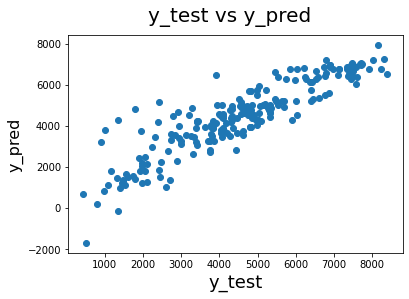

In [85]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)      


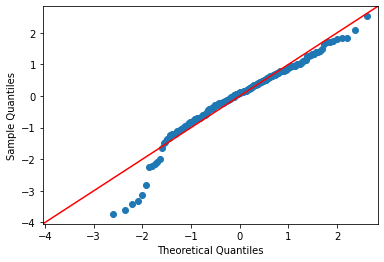

In [86]:
#Reference: https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
#           https://stats.stackexchange.com/questions/111010/interpreting-qqplot-is-there-any-rule-of-thumb-to-decide-for-non-normality/111013#111013

sm.qqplot((y_test - y_pred), fit=True, line='45')
plt.show()

Text(0.5, 0, 'Errors')

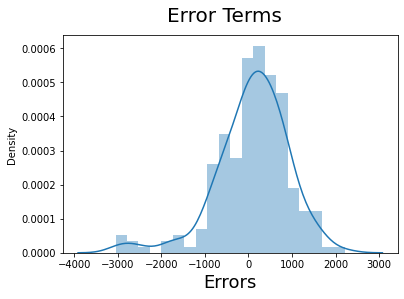

In [87]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_test - y_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)    

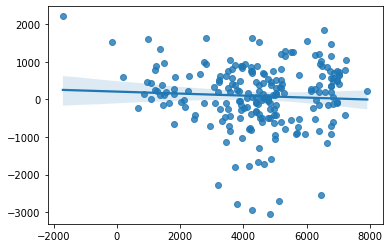

In [88]:
#plt.scatter(y_pred,(y_test - y_pred))
#plt.show()
sns.regplot(y_pred,y_test-y_pred,'r')
plt.show()

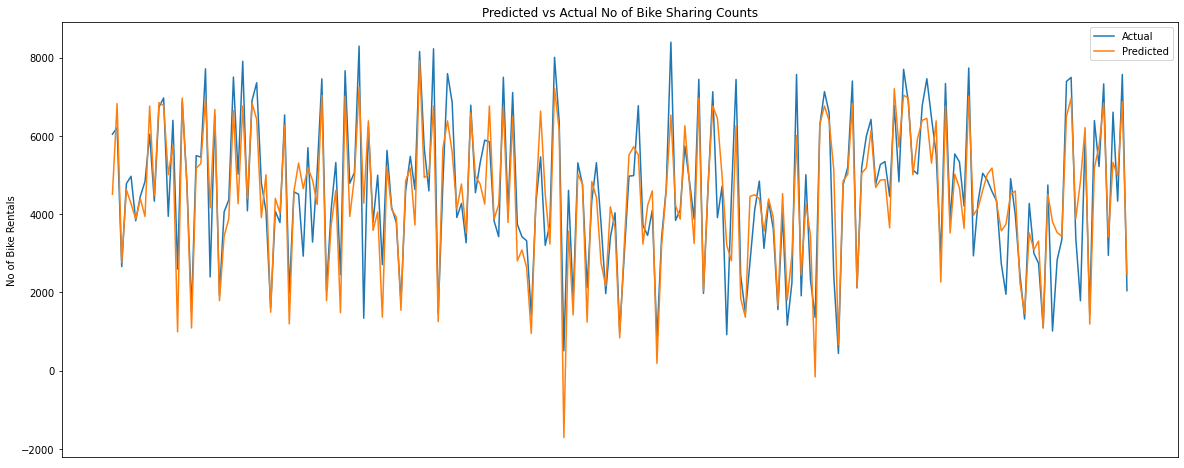

In [89]:
# Plotting Actual vs Predicted No of Shares 
fig,ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(20)
l1,=ax.plot(range(len(y_test)),y_test)
l2, = ax.plot(range(len(y_pred)),y_pred)
plt.legend([l1,l2],['Actual','Predicted'])
plt.title('Predicted vs Actual No of Bike Sharing Counts');
plt.ylabel('No of Bike Rentals')
plt.xticks([])
plt.show()


### ***Regression Metrics***

In [90]:
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
mse_train = mean_squared_error(y_train, y_train_cnt)
mae_train = mean_absolute_error(y_train, y_train_cnt)
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)
r2_train = r2_score(y_train, y_train_cnt)
MAPE_test = np.mean(np.abs(y_pred - y_test) / (y_test + 1e-5))
MAPE_train = np.mean(np.abs(y_train_cnt - y_train) / (y_train + 1e-5))
print('R-squared for train data:',round(r2_train,2))
print('R-squared for test data:',round(r2_test,2))
print('Mean Squared Error for train data',round(mse_train,3))
print('Mean Absolute Error for train data',round(mae_train,3))
print('Mean Squared Error for test data',round(mse_test,3))
print('Mean Absolute Error for test data',round(mae_test,3))
print('Mean Absolute Percentage Error for test data',round(MAPE_test,3))
print('Mean Absolute Percentage Error for train data',round(MAPE_train,3))

R-squared for train data: 0.83
R-squared for test data: 0.8
Mean Squared Error for train data 656200.357
Mean Absolute Error for train data 602.458
Mean Squared Error for test data 716282.418
Mean Absolute Error for test data 634.111
Mean Absolute Percentage Error for test data 0.213
Mean Absolute Percentage Error for train data 0.427
